In [1]:
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torchvision.transforms.v2 import Resize, Compose
from torchvision.transforms import Normalize
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import torchvision.models as models
from matplotlib import pyplot as plt
import data_utils as du
from tqdm import tqdm
import numpy as np

Загружаем изображения

In [2]:
dataset_path = 'ogyeiv2'
train_dataset = ImageFolder(dataset_path + '/train')
val_dataset = ImageFolder(dataset_path + '/test')

assert len(train_dataset.classes) == len(val_dataset.classes)
classes = train_dataset.classes
num_classes = len(classes)

for dataset in [train_dataset, val_dataset]:
    print(f"{len(dataset)} images of classes: {dataset.classes}")

2352 images of classes: ['acc_long_600_mg', 'advil_ultra_forte', 'akineton_2_mg', 'algoflex_forte_dolo_400_mg', 'algoflex_rapid_400_mg', 'algopyrin_500_mg', 'ambroxol_egis_30_mg', 'apranax_550_mg', 'aspirin_ultra_500_mg', 'atoris_20_mg', 'atorvastatin_teva_20_mg', 'betaloc_50_mg', 'bila_git', 'c_vitamin_teva_500_mg', 'calci_kid', 'cataflam_50_mg', 'cataflam_dolo_25_mg', 'cetirizin_10_mg', 'cold_fx', 'coldrex', 'concor_10_mg', 'concor_5_mg', 'condrosulf_800_mg', 'controloc_20_mg', 'covercard_plus_10_mg_2_5_mg_5_mg', 'coverex_4_mg', 'diclopram_75-mg_20-mg', 'dorithricin_mentol', 'dulsevia_60_mg', 'enterol_250_mg', 'favipiravir_meditop_200_mg', 'ibumax_400_mg', 'jutavit_c_vitamin', 'jutavit_cink', 'kalcium_magnezium_cink', 'kalium_r', 'koleszterin_kontroll', 'lactamed', 'lactiv_plus', 'laresin_10_mg', 'letrox_50_mikrogramm', 'lordestin_5_mg', 'merckformin_xr_1000_mg', 'meridian', 'metothyrin_10_mg', 'mezym_forte_10_000_egyseg', 'milgamma', 'milurit_300_mg', 'naprosyn_250_mg', 'narva_sr_1_

Посмотрим примеры изображений из датасета

urzinol
cataflam_50_mg
tritace_5_mg


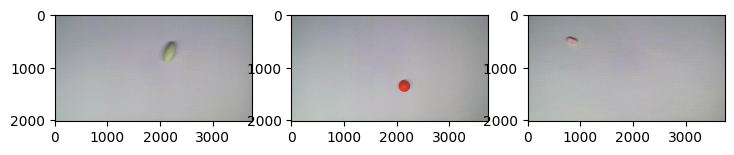

In [3]:
fig = plt.figure(figsize=(30, 10))
for index in range(1, 4):
    image, label = train_dataset[np.random.randint(0, len(train_dataset))]
    print(classes[label])
    plt.subplot(1, 10, index)
    plt.imshow(image, cmap='gray')

Видим, что изображения имеют высокое разрешение, порядка 8Мп.

Большая часть изображения это однородный фон, который не содержит никаких полезных фич. \
Полезных метаданных (например, centercrop, в который гарантированно поместится таблетка) по этому датасету я не нашёл, поэтому начал искать примеры статей на тему распознавания таблеток.

Нашёл вот эту:
https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/ipr2.13273

Авторы публикации описывают препроцесссинг датасета с помощью YOLO: 
 - детекция такблетки
 - кроп по ббоксу детекции

Поступим аналогично.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# В первый раз чистка датасета занимает 4-6 минут.
# Он будет сохранён на диск, при след. вызове ф-ии она вернёт управление тотчас.
mean, std = du.clean_up(
    train_dataset, device,
    "/home/vlabs/Documents/Yandex_Practicum_ML_CV/sprint_3/theme_4/lesson_1/ogyeiv2_clean/train")

if mean and std:
    print(f"Data set mean: {mean}, std: {std}")
else:
    # Во время проверки на вашей машине du.clean_up вернёт похожие значения.
    mean = [0.717, 0.644, 0.605]
    std = [0.110, 0.103, 0.103]

# mean и std валидационного датасета игнорируем, т. к. его размер очень мал.
du.clean_up(
    val_dataset, device,
    "/home/vlabs/Documents/Yandex_Practicum_ML_CV/sprint_3/theme_4/lesson_1/ogyeiv2_clean/test")

# Загружаем уже очищенные данные
dataset_path = '/home/vlabs/Documents/Yandex_Practicum_ML_CV/sprint_3/theme_4/lesson_1/ogyeiv2_clean'
train_dataset = ImageFolder(dataset_path + '/train')
val_dataset = ImageFolder(dataset_path + '/test')

Skip cleanup because /home/vlabs/Documents/Yandex_Practicum_ML_CV/sprint_3/theme_4/lesson_1/ogyeiv2_clean/train already exists
Skip cleanup because /home/vlabs/Documents/Yandex_Practicum_ML_CV/sprint_3/theme_4/lesson_1/ogyeiv2_clean/test already exists


Давайте ещё раз посмотрим на датасет чистки

teva_ambrobene_30_mg
vitamin_d3_fresenius_1000_ne
nurofen_forte_400_mg


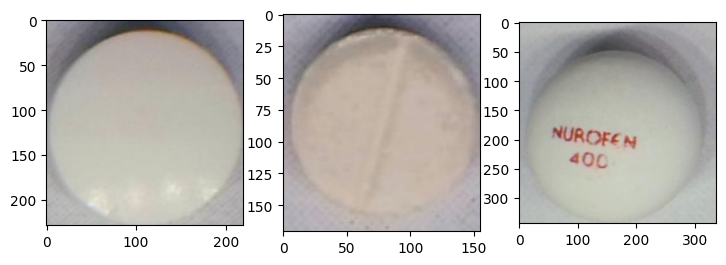

In [6]:
fig = plt.figure(figsize=(30, 10))
for index in range(1, 4):
    image, label = train_dataset[np.random.randint(0, len(train_dataset))]
    print(classes[label])
    plt.subplot(1, 10, index)
    plt.imshow(image, cmap='gray')

Выглядит гораздо лучше:
 - размер изображения составляет около 200-400 пикселей по длинной стороне
 - таблетка занимает почти всё изображение
  

Перейдём к выбору сети, используем в качестве классификатора модифицированную модель `MobileNet`.
Почему она ?
 - размер датасета очень мал, большая модель может его запомнить и переобучиться
 - у изображений мало фич: цвет, округлая форма, прямые линии, цифры.
 - число классов тоже очень мало

Заменим полносвязный слой, т. к. нам хватит 84 классов и дообучим.

In [7]:
model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
target_w = 224
target_h = 224

# Посмотрим на summary модели, чтобы найти какой слой надо заменить
summary(model, input_size=(3, target_h, target_w), device='cpu')

# Замораживаем слои, подменяем последний слой, размораживаем его
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Linear(
    in_features=576,
    out_features=num_classes)

for param in model.classifier.parameters():
    param.requires_grad = True

summary(model, input_size=(3, target_h, target_w), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

Отправляем модель на GPU для обучения

In [8]:
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
# Малый размер батча сильно улучшает процесс обучения.
# Полагаю, это вызвано тем что на каждый класс всего 28 изображений.
batch_size = 16

# Для достижения требуемой точности достаточно ресайза и нормализации.
# Аугментации не потребовалось.
transforms = Compose([
    Resize((target_w, target_h)),
    Normalize(mean, std),
])

train_dataset = du.OgyeivDataset(
    train_dataset,
    transforms,
    device)

val_dataset = du.OgyeivDataset(
    val_dataset,
    transforms,
    device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)


def train_one_epoch():
    running_loss = 0.
    avg_loss = 0.

    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        avg_loss = running_loss / (i + 1)

    return avg_loss

In [11]:
# Почему столько ?
# Подобрано экспериментально. При большем числе эпох ошибка уже  не уменьшается.
EPOCHS = 15
best_vloss = 1e5

for epoch in range(EPOCHS):
    print(f'Эпоха {epoch}')

    model.train(True)
    avg_loss = train_one_epoch()

    model.eval()
    running_vloss = 0.0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)
            running_vloss += criterion(voutputs, vlabels)

    avg_vloss = running_vloss / (i + 1)

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'pill_classifier_{epoch}.pt'
        torch.save(model.state_dict(), model_path)

    print(f'Ошибка обучения: {avg_loss}, ошибка валидации: {avg_vloss}')

Эпоха 0


100%|██████████| 147/147 [00:12<00:00, 11.38it/s]


Ошибка обучения: 2.827662100597304, ошибка валидации: 1.767822265625
Эпоха 1


100%|██████████| 147/147 [00:09<00:00, 14.72it/s]


Ошибка обучения: 1.2336212915628135, ошибка валидации: 1.0527548789978027
Эпоха 2


100%|██████████| 147/147 [00:09<00:00, 14.81it/s]


Ошибка обучения: 0.8347272891171125, ошибка валидации: 0.7350174784660339
Эпоха 3


100%|██████████| 147/147 [00:10<00:00, 13.47it/s]


Ошибка обучения: 0.6410722272331212, ошибка валидации: 0.6096764206886292
Эпоха 4


100%|██████████| 147/147 [00:11<00:00, 12.77it/s]


Ошибка обучения: 0.5262143826809059, ошибка валидации: 0.5239771604537964
Эпоха 5


100%|██████████| 147/147 [00:11<00:00, 12.84it/s]


Ошибка обучения: 0.4203029077272026, ошибка валидации: 0.43844103813171387
Эпоха 6


100%|██████████| 147/147 [00:11<00:00, 12.39it/s]


Ошибка обучения: 0.361486977460433, ошибка валидации: 0.39195793867111206
Эпоха 7


100%|██████████| 147/147 [00:12<00:00, 11.65it/s]


Ошибка обучения: 0.33155737513182115, ошибка валидации: 0.3609846532344818
Эпоха 8


100%|██████████| 147/147 [00:14<00:00, 10.42it/s]


Ошибка обучения: 0.2757939044006017, ошибка валидации: 0.3534958064556122
Эпоха 9


100%|██████████| 147/147 [00:11<00:00, 12.59it/s]


Ошибка обучения: 0.26128636776995495, ошибка валидации: 0.3317684531211853
Эпоха 10


100%|██████████| 147/147 [00:10<00:00, 13.37it/s]


Ошибка обучения: 0.22666854832042643, ошибка валидации: 0.3244379460811615
Эпоха 11


100%|██████████| 147/147 [00:12<00:00, 12.03it/s]


Ошибка обучения: 0.21841204153741298, ошибка валидации: 0.29550886154174805
Эпоха 12


100%|██████████| 147/147 [00:09<00:00, 14.85it/s]


Ошибка обучения: 0.20466202353032267, ошибка валидации: 0.2861380875110626
Эпоха 13


100%|██████████| 147/147 [00:09<00:00, 15.45it/s]


Ошибка обучения: 0.19287143594452313, ошибка валидации: 0.2874738872051239
Эпоха 14


100%|██████████| 147/147 [00:11<00:00, 12.57it/s]


Ошибка обучения: 0.1723254620775479, ошибка валидации: 0.2657865881919861


Возвращаем модель на CPU, строим отчёт

In [12]:
model.to('cpu')
model.eval()
labels_predicted = []
labels_true = []

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to('cpu'), labels.to('cpu')

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        labels_predicted.extend(predicted.numpy())
        labels_true.extend(labels.numpy())

print(classification_report(labels_true, labels_predicted, target_names=classes))

                                  precision    recall  f1-score   support

                 acc_long_600_mg       1.00      1.00      1.00         6
               advil_ultra_forte       1.00      1.00      1.00         6
                   akineton_2_mg       0.80      0.67      0.73         6
      algoflex_forte_dolo_400_mg       1.00      1.00      1.00         6
           algoflex_rapid_400_mg       1.00      1.00      1.00         6
                algopyrin_500_mg       1.00      1.00      1.00         6
             ambroxol_egis_30_mg       1.00      0.83      0.91         6
                  apranax_550_mg       1.00      1.00      1.00         6
            aspirin_ultra_500_mg       1.00      1.00      1.00         6
                    atoris_20_mg       1.00      1.00      1.00         6
         atorvastatin_teva_20_mg       1.00      0.83      0.91         6
                   betaloc_50_mg       1.00      1.00      1.00         6
                        bila_git     

_На каких 5 классах модель ошибается чаще всего?_
 - `akineton_2_mg`
 - `cataflam_50_mg`
 - `cetirizin_10_mg`
 - `cold_fx`

_Почему модель может ошибаться на этих классах?_
 - изображения для этих классов имеют очень мало фич. Например, фото таблетки "снизу", где из фич есть только форма (круглая, овальная) и цвет.

_На каких классах модель не совершает ошибок?_
 - на всех остальных

_Почему эти классы модель распознаёт безошибочно?_
 - судя по всему, достаточно фич для классификации (цвет, форма, маркировка, надсечки для дробления)

_Как можно улучшить точность классификатора?_
 - увеличить размер датасета. 28 изображений на класс это очень мало

_Как ещё можно проанализировать результаты и ошибки модели?_
 - качество обучения сильно зависит от размера батча, полагаю это вызвано малым числом данных
 - аугментация (поворот, отображение) сильно портят качество обучения сети
 - полагаю, что датасет имеет все признаки "сгенерированных" изображений, т. к. таблетки - результат промышленного производства. Поэтому аугментации, которые хорошо работают на generic imagery датасетах, здесь только всё портят.
 - полагаю, даже `MobileNet` избыточна. Возможно, хватат меньшего числа слоёв для извлечения фич, т. к. извлекать особо нечего.